In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
from PIL import Image
import pickle

from keras.layers import LSTM, Embedding, Dense, Reshape, Dropout
from keras.optimizers import Adam
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.translate.bleu_score import corpus_bleu

In [2]:
filename = 'Flickr8k_text/Flickr8k.token.txt'
file = open(filename, 'r')
doc = file.read()
print(doc[:411])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .



In [3]:
def load_descriptions(doc):
    d = dict()

    for line in doc.split('\n'):
        if line == '':
            continue
        word = line.split()
        index = word[0]
        index = index.split('#')
        index = index[0]
        #print(index)
        caption = word[1:]
        caption = ' '.join(caption)
        
        if index not in d:
            d[index] = []
        d[index].append(caption)
        
    return d

descriptions = load_descriptions(doc)
print('Loaded: {} '.format(len(descriptions)))

Loaded: 8092 


In [4]:
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    
    for key, value in descriptions.items():
        for i in range(len(value)):
            cap = value[i]
            cap = cap.split()

            cap = [word.lower() for word in cap]
            cap = [w.translate(table) for w in cap]
            cap = [word for word in cap if len(word) > 1]
            cap = [word for word in cap if word.isalpha()]
            value[i] =  ' '.join(cap)

clean_descriptions(descriptions)

In [5]:
def to_vocabulary(descriptions):
    vocab = set()
    for i in descriptions.values():
        for j in range(len(i)):
            v = i[j].split()
            vocab.update(v)
    return vocab

vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [6]:
def load_index_path(filename, images):
    file = open(filename, 'r')
    doc = file.read()
    image_index = []
    image_path = []
    for line in doc.split('\n'):
        if line == '':
            continue
        word = line.split()
        index = word[0]
        path = images + index
        
        if index in image_index: 
            continue
        else:
            image_index.append(index)
            
        if path in image_path: 
            continue
        else:
            image_path.append(path)
        
    return image_index, image_path

train_path = 'Flickr8k_text/Flickr_8k.trainImages.txt'
test_path = 'Flickr8k_text/Flickr_8k.testImages.txt'
images = 'Flicker8k_Dataset/'

train_index, train_path = load_index_path(train_path, images)
test_index, test_path = load_index_path(test_path, images)

print('Training Data: {}'.format(len(train_path)))
print('Test Data: {}'.format(len(test_path)))

Training Data: 6000
Test Data: 1000


In [7]:
def tr_descriptions(descriptions, tr_index):
    tr_descriptions = {}
    
    for i in range(len(tr_index)):
        if tr_index[i] in descriptions:
            tr_descriptions[tr_index[i]] = descriptions[tr_index[i]]
            
            for j in range(len(tr_descriptions[tr_index[i]])):
                tr_descriptions[tr_index[i]][j] = 'startseq ' + tr_descriptions[tr_index[i]][j] + ' endseq'
                
        else:
            continue
                
    return tr_descriptions
    
train_descriptions = tr_descriptions(descriptions, train_index)
print('Training descriptions: {}'.format(len(train_descriptions)))

test_descriptions = tr_descriptions(descriptions, test_index)
print('Test descriptions: {}'.format(len(test_descriptions)))

Training descriptions: 6000
Test descriptions: 1000


In [8]:
model = InceptionV3(weights='imagenet')

In [9]:
model_new = Model(model.input, model.layers[-2].output)

In [10]:
def encode(image_path):
    image = image.load_img(image_path, target_size=(299, 299))
    image = image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    feature = model_new.predict(image)
    feature = np.reshape(feature, feature.shape[1])
    return feature

In [ ]:
encoding_train = {}
encoding_test = {}
encoding_dev = {}

for img in train_path:
      encoding_train[img[len(images):]] = encode(img) 
                                                           
for img in test_path:
    encoding_test[img[len(images):]] = encode(img)

In [ ]:
with open('encode/encoding_train.pkl', 'wb') as f:
    pickle.dump(encoding_train, f)
    
with open('encode/encoding_test.pkl', 'wb') as f:
    pickle.dump(encoding_test, f)

In [11]:
train_features = pickle.load(open('encode/encoding_train.pkl', "rb"))
print('Train photos: {}'.format(len(train_features)))

test_features = pickle.load(open('encode/encoding_test.pkl', "rb"))
print('Test photos: {}'.format(len(test_features)))

Train photos: 6000
Test photos: 1000


In [12]:
def caption_list(descriptions):
    captions = []

    for keys, values in descriptions.items():
        for caption in values:
            captions.append(caption)

    return captions

all_train_captions = caption_list(train_descriptions)
len(all_train_captions)

30000

In [13]:
atleast = 10
word_counts = {}

for i in all_train_captions:
    word = i.split()
    for j in word:
        word_counts[j] = word_counts.get(j, 0) + 1

vocab = [key for key, values in word_counts.items() if values >= atleast]
print('Preprocessed words {} -> {}'.format(len(word_counts), len(vocab)))

Preprocessed words 7578 -> 1651


In [14]:
index_word = {}
word_index = {}

for count, v in enumerate(vocab, start = 1):
    index_word[count] = v
    word_index[v] = count

In [15]:
vocab_size = len(index_word) + 1 
vocab_size

1652

In [16]:
max_length = max(len(i.split()) for i in all_train_captions)
print('Max description length: {}'.format(max_length))

Max description length: 34


In [17]:
def data_generator(descriptions, photos, word_index, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0

    while 1:
        for key, desc_list in descriptions.items():
            n += 1
            photo = photos[key]
            for desc in desc_list:
                seq = [word_index[word] for word in desc.split(' ') if word in word_index]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

In [18]:
inputs1 = Input(shape=(2048,))

fe1 = Dropout(0.5)(inputs1) 

fe2 = Dense(256, activation='relu')(fe1) 

inputs2 = Input(shape=(max_length,))

se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)

se2 = Dropout(0.5)(se1)

se3 = LSTM(256)(se2)   

decoder1 = add([fe2, se3])  

decoder2 = Dense(256, activation='relu')(decoder1)

outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [19]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      422912      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [21]:
epochs = 30
batch = 4
steps = len(train_descriptions)//batch

In [ ]:
generator = data_generator(train_descriptions, train_features, word_index, max_length, batch)
model.fit(generator, epochs = epochs, steps_per_epoch = steps, verbose = 1)

In [ ]:
model.save_weights('model_weights\model_batch4_30.h5') 

In [ ]:
model.load_weights('model_weights\model_batch4_30.h5')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 30
batch = 8
steps = len(train_descriptions)//batch

In [ ]:
generator = data_generator(train_descriptions, train_features, word_index, max_length, batch)
model.fit(generator, epochs = epochs, steps_per_epoch = steps, verbose = 1)

In [ ]:
model.save_weights('model_weights\model_batch4_60.h5')

In [ ]:
model.load_weights('model_weights\model_batch4_60.h5')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 30
batch = 12
steps = len(train_descriptions)//batch

In [ ]:
generator = data_generator(train_descriptions, train_features, word_index, max_length, batch)
model.fit(generator, epochs = epochs, steps_per_epoch = steps, verbose = 1)

In [ ]:
model.save_weights('model_weights\model_batch4_90.h5')

In [22]:
model.load_weights('model_weights\model_batch4_90.h5')

In [23]:
def generate_captions(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_index[w] for w in in_text.split() if w in word_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

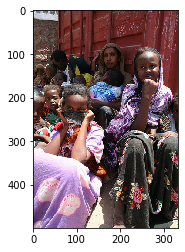

Caption: three young women are sitting on the ground


In [29]:
n = np.random.randint(1000)
pic = list(test_features.keys())[n]
image = test_features[pic].reshape((1,2048))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", generate_captions(image))